In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import library

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import os
import zipfile
import tqdm

file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/Multimedia/Multimedia_dataset.zip')

!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"

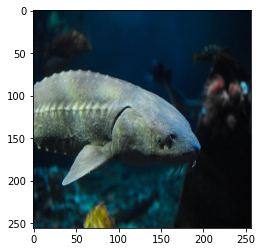

In [4]:
import torch
import os
import matplotlib.pyplot as plt

train_root = './train'
val_root = './validation'

train_examples = os.listdir(train_root)
val_examples = os.listdir(val_root)

img = plt.imread(train_root + '/' + train_examples[0])
plt.imshow(img)
plt.show()

# Noising

In [5]:
# data+noise 코드
def add_noise(img, noise) :
    model_input = img + noise
    noise_image = torch.clamp(model_input, 0, 1)
    
    return noise_image

image shape (256, 256, 3)


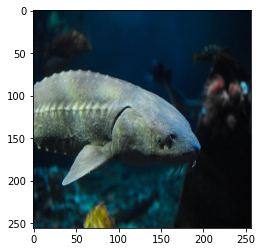

In [27]:
import torch
import torch.utils.data  as data
import os
from PIL import Image
import matplotlib.pyplot as plt

class NoiseDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(NoiseDataset, self).__init__()
    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = NoiseTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test")
      self.examples = [os.path.join(self.root_path, "test", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)
  
  def __repr__(self) :
    return "NoiseDataset(mode = {}, image_size = {})" .\
    format(self.mode, self.size)
  
  def __getitem__(self, idx):
    file_name = self.examples[idx]
    image = Image.open(file_name)

    if self.mode == "testing":
      input_img = self.transforms(image)
      #file_name = "image_%0.6d.png" % int(os.path.basename(test_file_name).split('.')[0])
      #sample = {"img" : input_img, "file_name" : file_name}
      return input_img

    else:
      clean, noise = self.transforms(image)
      noise_img = add_noise(clean, noise)
      return noise_img, clean
    
print('image shape', img.shape)
plt.imshow(img)
plt.show()

In [9]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import random

class NoiseTransform(object):
  def __init__(self, size=180, mode="training"):
    super(NoiseTransform, self).__init__()
    self.size = size 
    self.mode = mode
  
  def gaussian_noise(self, img):
    mean = 0
    stddev = 25
    noise = Variable(torch.zeros(img.size()))
    noise = noise.data.normal_(mean, stddev/255.)

    return noise

  def __call__(self, img):
    if (self.mode == "training") | (self.mode == "validation"):
      self.gt_transform = transforms.Compose([
        # transforms.RandomCrop(self.size), 
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ToTensor()])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.gt_transform(img), self.noise_transform(img)

    elif self.mode == "testing":
      self.gt_transform = transforms.Compose([
        # transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      return self.gt_transform(img)
    else:
      return NotImplementedError

In [14]:
import torch
import torch.utils.data  as data
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = NoiseDataset(root_path, 128)
train_dataset.set_mode("training")
train_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = NoiseDataset(root_path, 128)
val_dataset.set_mode("validation")
val_dataloader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)

test_dataset = NoiseDataset(root_path, 128)
test_dataset.set_mode("testing")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Plotting and Image Funtions

In [15]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [51]:
def plot(exp, fig, axes, noisy, img, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()

    myimshow(img, ax=axes[0][0])
    axes[0][0].set_title('Original image')
    myimshow(noisy, ax=axes[0][1])
    axes[0][1].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][2])
    axes[0][2].set_title('Denoised image')

    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    axes[1][0].set_title('training loss')
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="psnr")
    axes[1][1].set_title('psnr')
         
    
    plt.tight_layout()
    fig.canvas.draw()

## Check Noise Image

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Text(0.5, 1.0, 'Noise Image')

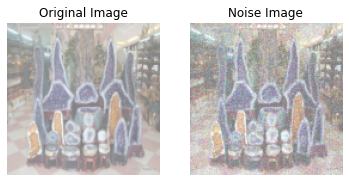

In [22]:
x = train_dataset[30]
fig, (ax1, ax2) = plt.subplots(ncols=2)
myimshow(x[1], ax=ax1)
ax1.set_title("Original Image")
myimshow(x[0], ax=ax2)
ax2.set_title("Noise Image")

# DUDnCNN

In [23]:
import nntools as nt

class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.loss = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.loss(y, d)

In [25]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
        
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        self.count = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        mse = y-d
        mse = mse*mse
        mse = torch.sum(mse).float()
        self.running_psnr += 10 * torch.log10((4*y.numel()) / mse)
        self.count += 1
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.count   
        return {'loss': loss, 'psnr': psnr}

In [28]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

# Training

In [30]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp61 = nt.Experiment(net, train_dataset, val_dataset, adam, stats_manager, batch_size = 4,
                     output_dir="denoising61", perform_validation_during_training=True)

Start/Continue training from epoch 30


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Finish training for 30 epochs


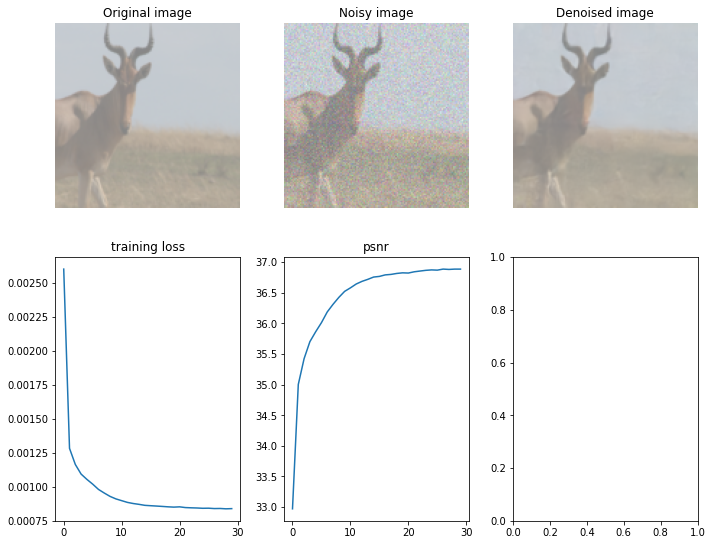

In [52]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,8))
exp61.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=train_dataset[500][0], img = train_dataset[500][1]))

# Loss and PSNR

In [46]:
eval6 = exp61.evaluate()

print("DUDnCNN loss", eval6["loss"])
print("DUDnCNN psnr", eval6["psnr"].cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


DUDnCNN loss 0.0008614767589606345
DUDnCNN psnr 36.756165
